# Proyek Klasifikasi Gambar: [Waste Classification](https://www.kaggle.com/datasets/techsash/waste-classification-data)
- **Nama:** Muhammad Tsaqif
- **Email:** mtsaqif08@gmail.com
- **ID Dicoding:** MC004D5Y2062

## Import Library

In [41]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import json
import collections
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import display, HTML
from google.colab import files

import cv2
import kagglehub
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [42]:
# Setup GPU untuk mempercepat training
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Data Preparation

In [43]:
# Fungsi untuk mengecek resolusi gambar
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

### Data Loading

In [44]:
print("Downloading dataset...")
try:
    dataset_path = kagglehub.dataset_download("techsash/waste-classification-data")
    print(f"Dataset path: {dataset_path}")
except Exception as e:
    print(f"Failed to download dataset: {e}")

Dataset path: /kaggle/input/waste-classification-data


In [45]:
# Define paths
train_path = os.path.join(dataset_path, "DATASET/TRAIN")
test_path = os.path.join(dataset_path, "DATASET/TEST")

In [46]:
# Verifikasi resolusi gambar
print("\nChecking image resolutions in training set:")
print_images_resolution(train_path)


Checking image resolutions in training set:
R: 9999
- (77, 252)
- (410, 123)
- (206, 244)
- (315, 160)
- (141, 273)
- (253, 194)
- (360, 140)
- (177, 284)
- (201, 251)
- (221, 229)
- (186, 271)
- (189, 267)
- (150, 196)
- (276, 183)
- (88, 221)
- (226, 191)
- (334, 151)
- (280, 180)
- (365, 138)
- (272, 185)
- (220, 147)
- (257, 196)
- (292, 172)
- (141, 250)
- (80, 243)
- (484, 104)
- (284, 177)
- (173, 291)
- (380, 132)
- (209, 241)
- (165, 305)
- (93, 209)
- (306, 164)
- (252, 193)
- (349, 144)
- (298, 169)
- (276, 169)
- (244, 207)
- (233, 216)
- (376, 134)
- (345, 146)
- (182, 268)
- (169, 298)
- (237, 213)
- (325, 155)
- (356, 142)
- (228, 222)
- (201, 250)
- (221, 228)
- (192, 192)
- (224, 224)
- (236, 189)
- (186, 270)
- (513, 98)
- (189, 266)
- (330, 153)
- (276, 182)
- (417, 121)
- (217, 194)
- (394, 128)
- (225, 225)
- (160, 315)
- (241, 160)
- (216, 234)
- (336, 150)
- (282, 179)
- (274, 184)
- (422, 119)
- (399, 126)
- (83, 235)
- (294, 171)
- (160, 180)
- (180, 195)
- (2

### Data Preprocessing

In [47]:
# Fungsi untuk memuat dataset dengan augmentasi
def load_dataset(base_path, image_size=(224, 224), batch_size=32, augment=False):
    def process_image(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [256, 256])  # Resize ke ukuran lebih besar dulu
        img = tf.image.random_crop(img, size=[image_size[0], image_size[1], 3])  # Random crop ke ukuran target
        img = tf.cast(img, tf.float32) / 255.0

        if augment:
            img = tf.image.random_flip_left_right(img)
            if tf.random.uniform(()) > 0.5:
                img = tf.image.random_brightness(img, max_delta=0.1)
                img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
            img = tf.clip_by_value(img, 0.0, 1.0)

        return img, label

    image_paths = []
    labels = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
                labels.append(os.path.basename(root))

    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_encoded))
    ds = ds.shuffle(len(image_paths)) if augment else ds
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds, le

#### Split Dataset

In [48]:
# Memuat dataset dengan augmentasi untuk training dan tanpa augmentasi untuk test
train_ds, le = load_dataset(train_path, augment=True, batch_size=64)
test_ds, _ = load_dataset(test_path, batch_size=64)

# Split Dataset
# 80% training, 10% validation, 10% test (test set sudah terpisah)
train_size = int(0.8 * len(train_ds))
val_ds = train_ds.skip(train_size)
train_ds = train_ds.take(train_size)

# Hitung class weights untuk menangani imbalance class
print("\nCalculating class weights...")
all_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)


Calculating class weights...
Class weights: {0: np.float64(0.8942622138539292), 1: np.float64(1.134095764735453)}


Jumlah data training: 18048
Jumlah data validation: 4516
Jumlah data test: 2513
Total seluruh data: 25077

Distribusi kelas pada training set:
O: 10017 samples
R: 8031 samples


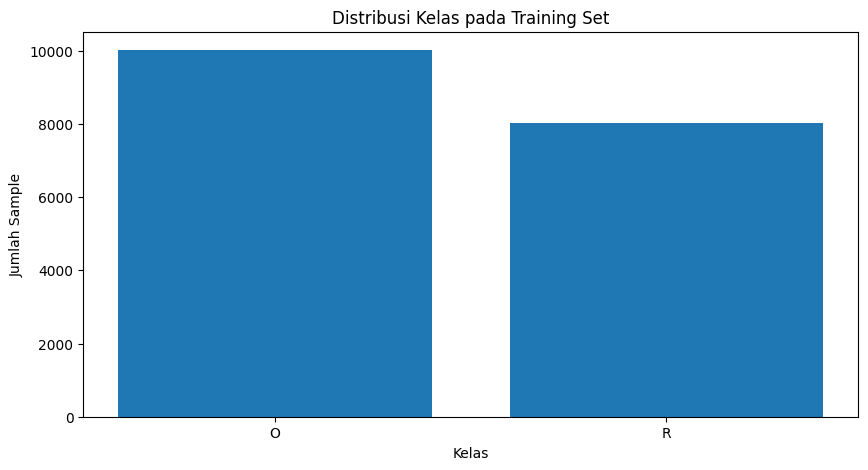


Jumlah kelas: 2
Nama kelas: [np.str_('O'), np.str_('R')]


In [49]:
# Menghitung jumlah data pada setiap set
def count_data(dataset):
    count = 0
    for _, labels in dataset:
        count += labels.shape[0]
    return count

train_count = count_data(train_ds)
val_count = count_data(val_ds)
test_count = count_data(test_ds)

print(f"Jumlah data training: {train_count}")
print(f"Jumlah data validation: {val_count}")
print(f"Jumlah data test: {test_count}")
print(f"Total seluruh data: {train_count + val_count + test_count}")

# Menghitung distribusi kelas pada training set
print("\nDistribusi kelas pada training set:")
train_classes = np.concatenate([y for x, y in train_ds], axis=0)
unique, counts = np.unique(train_classes, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"{le.classes_[cls]}: {cnt} samples")

# Visualisasi distribusi kelas
plt.figure(figsize=(10, 5))
plt.bar(le.classes_, counts)
plt.title('Distribusi Kelas pada Training Set')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sample')
plt.show()

# Verifikasi jumlah kelas
print(f"\nJumlah kelas: {len(le.classes_)}")
print(f"Nama kelas: {list(le.classes_)}")

## Modelling

In [50]:
def build_model(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential([
        # Enhanced Stem Block
        layers.Conv2D(32, (7, 7), strides=2, padding='same', activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2, padding='same'),

        # Inception-like Block
        layers.Conv2D(64, (1, 1), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Convolution Block
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), strides=2, padding='same', activation='relu'),
        layers.BatchNormalization(),

        # Convolution Block
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Final Layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Membangun model
print("\nBuilding model...")
sequential_model = build_model(num_classes=len(le.classes_))
sequential_model.summary()


Building model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 826,498 (3.15 MB)

 Trainable params: 825,154 (3.15 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [51]:
# Kompilasi model dengan pengaturan optimal
model = build_model(num_classes=len(le.classes_))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks untuk meningkatkan akurasi
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

In [52]:
# Training model
print("\nStarting training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)


Starting training...
Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 73s 220ms/step - accuracy: 0.7859 - loss: 3.9386 - val_accuracy: 0.6470 - val_loss: 0.8004 - learning_rate: 0.0010
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 235ms/step - accuracy: 0.8476 - loss: 0.4866 - val_accuracy: 0.4723 - val_loss: 2.5780 - learning_rate: 0.0010
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 67s 183ms/step - accuracy: 0.8481 - loss: 0.3949 - val_accuracy: 0.7730 - val_loss: 0.5473 - learning_rate: 0.0010
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 65s 232ms/step - accuracy: 0.8577 - loss: 0.3717 - val_accuracy: 0.8470 - val_loss: 0.3807 - learning_rate: 0.0010
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 68s 181ms/step - accuracy: 0.8623 - loss: 0.3618 - val_accuracy: 0.6218 - val_loss: 0.9354 - learning_rate: 0.0010
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - accuracy: 0.8696 - loss: 0.3462 - val_accuracy: 0.8645 - val_loss: 0.3414 - learning_rate: 0.0010
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 180m

## Evaluasi dan Visualisasi

In [53]:
# Evaluasi pada test set
print("\nEvaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")


Evaluating on test set...
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.8790 - loss: 0.3347

Test accuracy: 0.9129


In [54]:
# Classification report
y_true = []
y_pred = []
for images, labels in tqdm(test_ds, desc="Evaluating"):
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

           O       0.89      0.96      0.92      1401
           R       0.95      0.85      0.90      1112

    accuracy                           0.91      2513
   macro avg       0.92      0.91      0.91      2513
weighted avg       0.91      0.91      0.91      2513



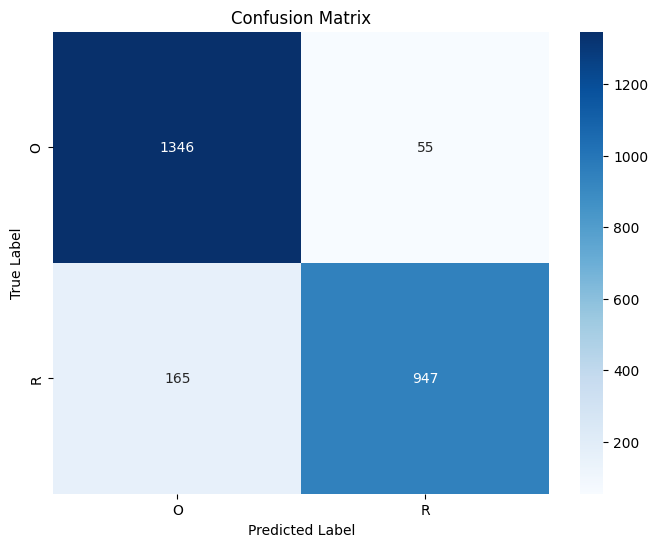

In [55]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

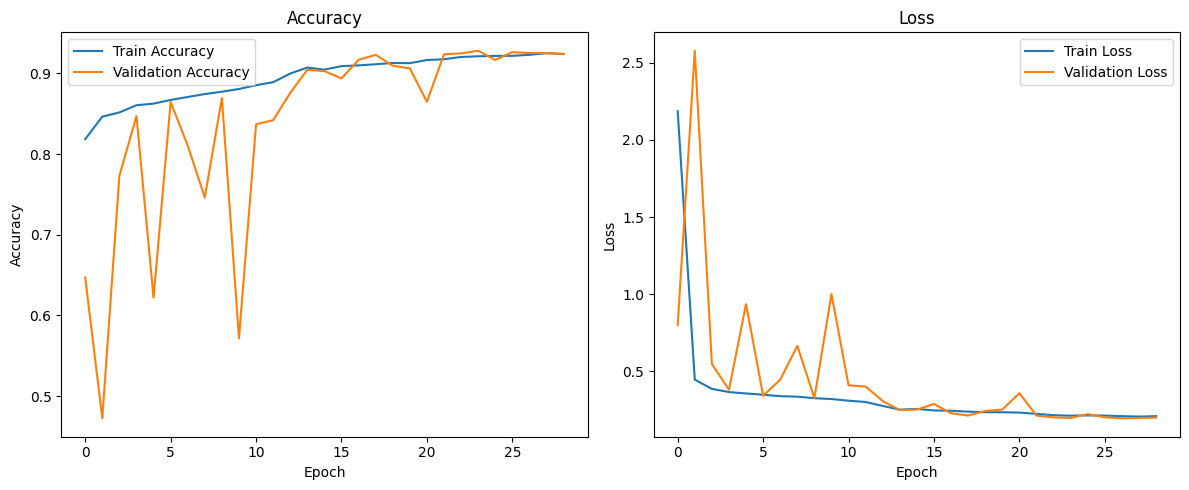

In [56]:
# Plot training history (akurasi dan loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [57]:
# Buat struktur folder
os.makedirs('tfjs_model', exist_ok=True)
os.makedirs('tflite', exist_ok=True)
os.makedirs('saved_model', exist_ok=True)

# 1. Simpan SavedModel
tf.saved_model.save(model, 'saved_model')
print("SavedModel format saved in 'saved_model' folder")

# 2. Konversi ke TF-Lite dan simpan label
# Convert model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

# Simpan label (asumsikan le adalah LabelEncoder Anda)
with open('tflite/label.txt', 'w') as f:
    for idx, class_name in enumerate(le.classes_):
        f.write(f"{idx}:{class_name}\n")

print("TFLite model and labels saved in 'tflite' folder")

# 3. Konversi ke TFJS
try:
    import tensorflowjs as tfjs
    # Versi sederhana tanpa split_weights_by_layer
    tfjs.converters.save_keras_model(model, 'tfjs_model')

    # Buat file metadata untuk TFJS
    metadata = {
        "labels": le.classes_.tolist(),
        "input_shape": model.input_shape[1:3],
        "output_name": model.output_names[0]
    }
    with open('tfjs_model/metadata.json', 'w') as f:
        json.dump(metadata, f)

    print("TFJS model saved in 'tfjs_model' folder")
except ImportError:
    print("TensorFlow.js not installed, skipping TFJS conversion")
except Exception as e:
    print(f"Error converting to TFJS: {str(e)}")

# 4. Simpan label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print("\nAll model formats saved successfully!")
print("Folder structure created:")
print("""
├───tfjs_model
│   ├───group1-shard1of1.bin
│   ├───model.json
│   └───metadata.json
├───tflite
│   ├───model.tflite
│   └───label.txt
├───saved_model
│   ├───saved_model.pb
│   └───variables
└───label_encoder.pkl
""")

SavedModel format saved in 'saved_model' folder
Saved artifact at '/tmp/tmpu5we_4nu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_84')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132113871197904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698057168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698058512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698057744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698056016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698058320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698059856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698060432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698060816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132113698059664: TensorSpec(shape

TFLite model and labels saved in 'tflite' folder
failed to lookup keras version from the file,
    this is likely a weight only file
Error converting to TFJS: 'Sequential' object has no attribute 'output_names'

All model formats saved successfully!
Folder structure created:

├───tfjs_model
│   ├───group1-shard1of1.bin
│   ├───model.json
│   └───metadata.json
├───tflite
│   ├───model.tflite
│   └───label.txt
├───saved_model
│   ├───saved_model.pb
│   └───variables
└───label_encoder.pkl



## Inference

Saving sample image.jpg to sample image (2).jpg


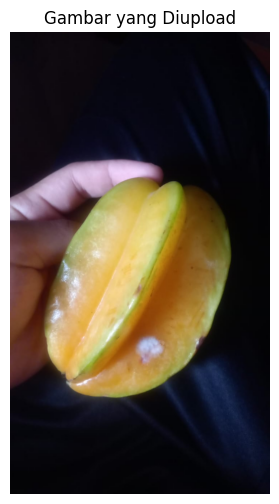


Hasil Prediksi:
- Jenis Sampah: O
- Kategori: Organik
- Tingkat Kepercayaan: 88.45%


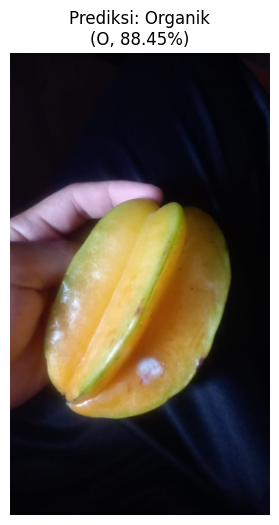

In [61]:
def upload_and_predict():
    # 1. Upload gambar
    uploaded = files.upload()

    if not uploaded:
        print("Tidak ada file yang diupload!")
        return

    # Ambil nama file pertama yang diupload
    file_name = next(iter(uploaded))

    # 2. Tampilkan gambar
    img = plt.imread(file_name)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Gambar yang Diupload")
    plt.show()

    # 3. Lakukan preprocessing dan inference
    try:
        # Jalankan prediksi
        class_name, confidence, waste_type = tflite_inference_with_organic_label(
            'tflite/model.tflite',
            file_name,
            le
        )

        # Tampilkan hasil
        print("\n" + "="*50)
        print(f"Hasil Prediksi:")
        print(f"- Jenis Sampah: {class_name}")
        print(f"- Kategori: {waste_type}")
        print(f"- Tingkat Kepercayaan: {confidence:.2%}")
        print("="*50)

        # Tampilkan gambar dengan annotasi
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediksi: {waste_type}\n({class_name}, {confidence:.2%})")
        plt.show()

    except Exception as e:
        print(f"Error saat melakukan prediksi: {str(e)}")

# Fungsi inference yang sudah dimodifikasi
def tflite_inference_with_organic_label(model_path, image_path, label_encoder):
    # Load model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Preprocess image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension

    # Run inference
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    preds = interpreter.get_tensor(output_details[0]['index'])

    # Get class and confidence
    class_idx = np.argmax(preds[0])
    confidence = preds[0][class_idx]
    class_name = label_encoder.inverse_transform([class_idx])[0]

    # Klasifikasi Anorganik/Organik
    if class_name.startswith('R'):  # Anorganik
        waste_type = "Anorganik"
    else:  # Organik
        waste_type = "Organik"

    return class_name, float(confidence), waste_type

# Tampilkan instruksi
display(HTML("""
<h3>Instruksi:</h3>
<ol>
  <li>Klik tombol 'Choose Files' untuk mengupload gambar</li>
  <li>Tunggu hingga gambar ditampilkan</li>
  <li>Hasil prediksi akan muncul di bawah gambar</li>
</ol>
"""))

# Jalankan fungsi upload dan prediksi
upload_and_predict()